### Bike Sharing Data Set 
Data source: https://code.datasciencedojo.com/toobamukhtar/datasets/tree/5a283b2d7a66be24b8f709a4335729b96990d683/Bike%20Sharing


### Predict bike rental count (hourly/daily) based on the environmental & seasonal settings

Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions, precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors.

This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 for Capital 
bikeshare system with the corresponding weather and seasonal information.

This dataset contains 2 files: Bike sharing counts aggregated on hourly basis (hour.csv - 17379 rows, 17 columns) & bike sharing counts aggregated on daily basis (day.csv - 731 rows, 16 columns)
___

### Challenge: 
Build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.ticker as ticker
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
bike_filepath = '/Users/wesamazaizeh/Desktop/Thinkful_Main_Course/Similarity_Models/Bike Sharing/day.csv'
bike_df = pd.read_csv(bike_filepath)
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Data preperation

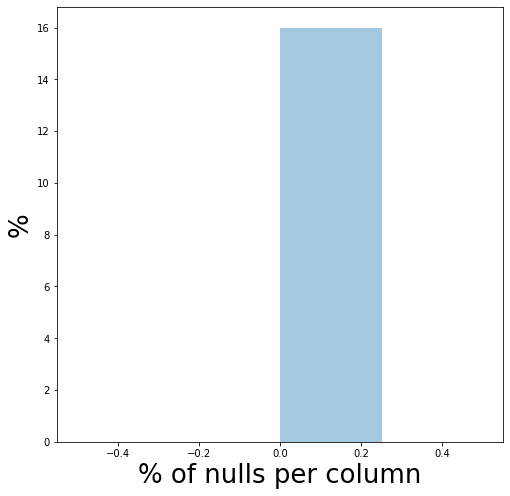

In [3]:
# visualize % of nulls per column
plt.figure(figsize=(8,8))
sns.distplot(bike_df.isnull().sum()/bike_df.shape[0]*100, kde=False)
plt.xlabel('% of nulls per column', size=26)
plt.ylabel('%', size=26)
plt.show()

- No missing data

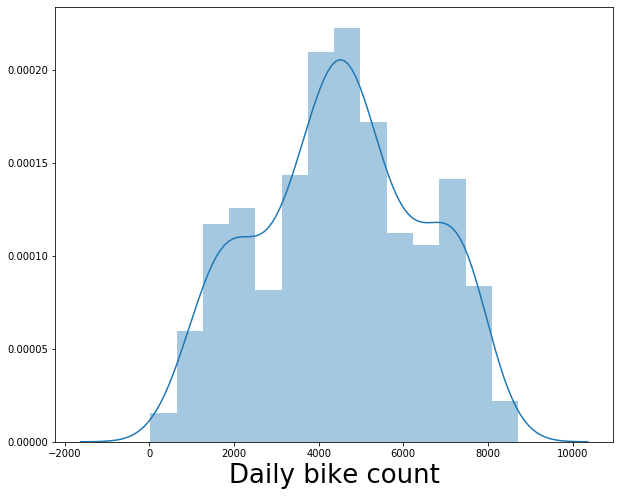

In [4]:
# distribution of target variable
plt.figure(figsize=(10,8))
sns.distplot(bike_df.cnt)
plt.xlabel('Daily bike count', size=26)
plt.show()

- The target variable seems normally distributed

## Feature selection:

### 1. Using PCA to find features that contribute the most to variance within samples

In [182]:
bike_df.iloc[:,2:-3].shape

(731, 11)

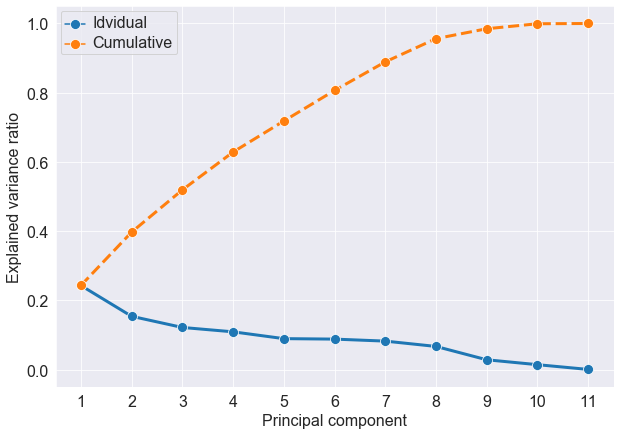

PCA 1st component explains 24.3% of the expenditure variance


In [186]:
# PCA of most informative features
data = bike_df.iloc[:,2:-3]

z_data = StandardScaler().fit_transform(data)
pca_res = PCA().fit(z_data)

plt.figure(figsize = (10,7))
sns.set_context( rc={'lines.markersize': 10, 'xtick.labelsize': 16, 'ytick.labelsize': 16}) # override marker and ticklabel size
g = sns.lineplot(y=pca_res.explained_variance_ratio_, x=list(range(1,12)), marker="o", label='Idvidual')
sns.lineplot(y=pca_res.explained_variance_ratio_.cumsum(), x=list(range(1,12)), marker="o", label='Cumulative')
sns.set_style('darkgrid')
plt.setp(g.lines,linewidth=3) # for line width
g.lines[1].set_linestyle("--") # for line style
plt.setp(g.get_legend().get_texts(), fontsize='16') # for legend text
plt.xlabel('Principal component', fontsize='16') # x-axis label
plt.ylabel('Explained variance ratio', fontsize='16') # y-axis label
g.set(xticks=list(range(1,12)))
plt.show()

print('PCA 1st component explains {:.3}% of the expenditure variance'.format(pca_res.explained_variance_ratio_[0]*100))

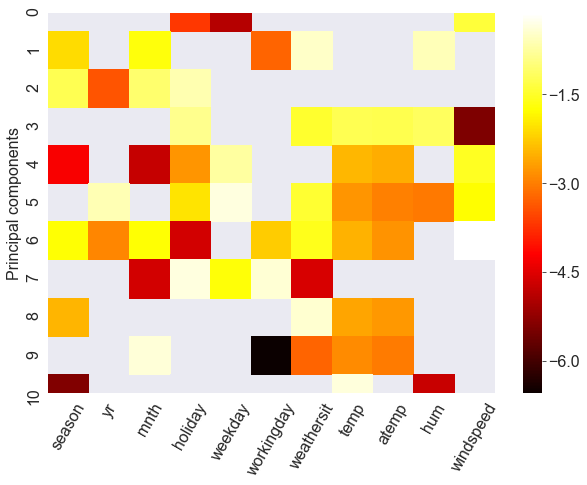

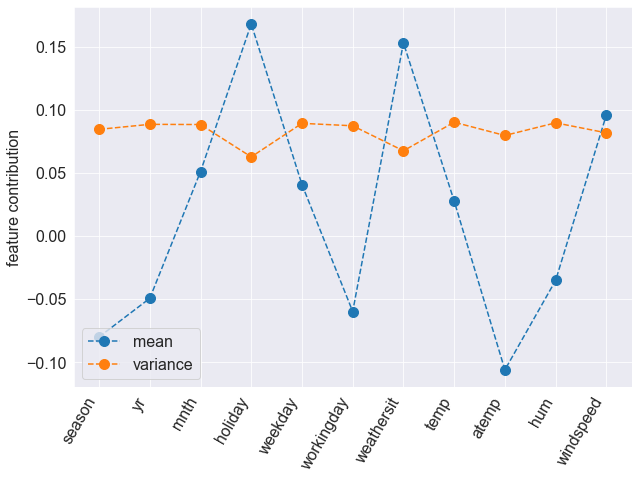

In [199]:
# heatmap of variables vs principal components
fig, ax = plt.subplots(figsize=(10,7)) 
cols = list(bike_df.iloc[:,2:-1].columns)
sns.set_context(rc={'axes.labelsize':16})
sns.heatmap(np.log(pca_res.inverse_transform(np.eye(data.shape[1]))), cmap="hot")
ax.set_xticklabels(cols) # set x-ticks labels
plt.xticks(rotation=60) # rotate x-tixks so they fit next to each other
plt.ylabel('Principal components') # y-axis label
plt.show()

# mean and variance of variables contributing to 1st principal component
pca_inv_res = pca_res.inverse_transform(np.eye(data.shape[1]))
fig, ax = plt.subplots(figsize=(10,7)) 
plt.plot(pca_inv_res.mean(axis=0), '--o', label = 'mean')
plt.plot(np.square(pca_inv_res.std(axis=0)), '--o', label = 'variance')
plt.ylabel('feature contribution', fontsize=16);
ax.xaxis.set_major_locator(ticker.FixedLocator((list(range(13))))) # manually setting xticks position
ax.xaxis.set_major_formatter(ticker.FixedFormatter((cols))) # manually setting xticks labels
ax.set_xticklabels(cols, rotation=60, ha='right') # rotating and correcting xticks position
plt.legend(loc='lower left', fontsize=16)
plt.show()

PCA dimensionality reduction doesn't seem efficient enough for this model. In order to explain more than 90% of the variance in the outcome, we 9 or 9 PC are needed, which is not a great improvement from the 13 original features.
## 2. Using highest correlation to target value and low correlation with other features

In [206]:
corr = bike_df.drop(['casual', 'registered', 'instant'], axis=1).corr()
corr.style.background_gradient(cmap='RdBu_r')

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
season,1,-0.00184434,0.83144,-0.0105367,-0.00307988,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,0.4061
yr,-0.00184434,1,-0.00179243,0.00795431,-0.00546077,-0.00201262,-0.0487265,0.0476036,0.0461061,-0.110651,-0.0118171,0.56671
mnth,0.83144,-0.00179243,1,0.0191909,0.00950931,-0.00590095,0.0435281,0.220205,0.227459,0.222204,-0.207502,0.279977
holiday,-0.0105367,0.00795431,0.0191909,1,-0.10196,-0.253023,-0.0346268,-0.0285555,-0.0325067,-0.0159375,0.00629151,-0.0683477
weekday,-0.00307988,-0.00546077,0.00950931,-0.10196,1,0.0357897,0.0310875,-0.000169962,-0.00753713,-0.0522321,0.0142821,0.0674434
workingday,0.012485,-0.00201262,-0.00590095,-0.253023,0.0357897,1,0.0612004,0.0526598,0.0521823,0.024327,-0.0187965,0.0611561
weathersit,0.019211,-0.0487265,0.0435281,-0.0346268,0.0310875,0.0612004,1,-0.120602,-0.121583,0.591045,0.0395111,-0.297391
temp,0.334315,0.0476036,0.220205,-0.0285555,-0.000169962,0.0526598,-0.120602,1,0.991702,0.126963,-0.157944,0.627494
atemp,0.342876,0.0461061,0.227459,-0.0325067,-0.00753713,0.0521823,-0.121583,0.991702,1,0.139988,-0.183643,0.631066
hum,0.205445,-0.110651,0.222204,-0.0159375,-0.0522321,0.024327,0.591045,0.126963,0.139988,1,-0.248489,-0.100659


In [211]:
# selecting features that are highly correlated (>0.5) with target
cor_keep = corr['cnt'][np.abs(corr['cnt']) > 0.5].sort_values(ascending=False)

# eliminate intercorrelated feature
corr2 = bike_df[cor_keep.index].corr()
corr2.style.background_gradient(cmap='RdBu_r')

,cnt,atemp,temp,yr
cnt,1,0.631066,0.627494,0.56671
atemp,0.631066,1,0.991702,0.0461061
temp,0.627494,0.991702,1,0.0476036
yr,0.56671,0.0461061,0.0476036,1


In [212]:
# drop temp since atemp is more highly correlated with count
cor_keep.drop('temp', inplace=True)

corr3 = bike_df[cor_keep.index].corr()
corr3.style.background_gradient(cmap='RdBu_r')

,cnt,atemp,yr
cnt,1,0.631066,0.56671
atemp,0.631066,1,0.0461061
yr,0.56671,0.0461061,1


## OLS regression

In [222]:
data = bike_df[cor_keep.drop('cnt').index]
target = bike_df.cnt

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.2)

print("The number of observations in the training set is {}".format(data_train.shape[0]))
print("The number of observations in the test set is {}".format(data_test.shape[0]))

# data_train = sm.add_constant(data_train) # eliminated based on p_value of model fit

# fit an OLS model using statsmodels
results = sm.OLS(target_train, data_train).fit()

# print the summary results
print(results.summary())

The number of observations in the training set is 584
The number of observations in the test set is 147
                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              5568.
Date:                Tue, 22 Oct 2019   Prob (F-statistic):                        0.00
Time:                        21:28:40   Log-Likelihood:                         -4913.6
No. Observations:                 584   AIC:                                      9831.
Df Residuals:                     582   BIC:                                      9840.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                

- Constant P value > 0.05 (0.5). Therefore it was removed and that increased R-sqr from ~0.69 to ~0.95

In [234]:
features = cor_keep.drop('cnt').index
data = bike_df[features]
data['yr_atemp'] = data.yr * data.atemp
target = bike_df.cnt

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.2)

print("The number of observations in the training set is {}".format(data_train.shape[0]))
print("The number of observations in the test set is {}".format(data_test.shape[0]))

# sm_data_train = sm.add_constant(data_train)

# fit an OLS model using statsmodels
results2 = sm.OLS(target_train, data_train).fit()

# print the summary results
print(results2.summary())

The number of observations in the training set is 584
The number of observations in the test set is 147
                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              4105.
Date:                Tue, 22 Oct 2019   Prob (F-statistic):                        0.00
Time:                        21:32:09   Log-Likelihood:                         -4886.2
No. Observations:                 584   AIC:                                      9778.
Df Residuals:                     581   BIC:                                      9791.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                

- Adding the interaction term between year and apparent temp lead to only slight improvememnt in R-sqr, from ~0.950 to ~0.955

## KNN regression model

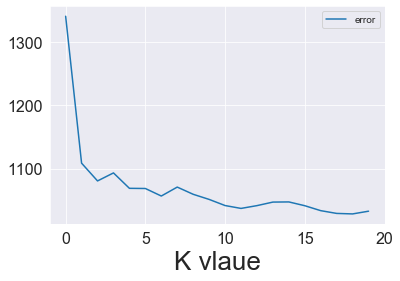

K value with biggest difference in slope: 17
Unweighted Accuracy: -0.64 (+/- 2.04)
Weighted Accuracy: -0.89 (+/- 2.07)


In [298]:
# determine K
knn = neighbors.KNeighborsRegressor(n_neighbors=100)
knn_w = neighbors.KNeighborsRegressor(n_neighbors=100, weights='distance')

data = bike_df[cor_keep.drop('cnt').index]
target = bike_df.cnt
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.2)

rmse_val = []
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(data_train, target_train)
    pred=model.predict(data_test)
    error = sqrt(mean_squared_error(target_test,pred))
    rmse_val.append(error)

curve = pd.DataFrame(rmse_val)
curve.plot()
plt.xlim((-1,20))
plt.xlabel('K vlaue', size=26)
plt.legend(['error'] )
plt.show()

# build model with K=4
knn = neighbors.KNeighborsRegressor(n_neighbors=4)
knn_w = neighbors.KNeighborsRegressor(n_neighbors=4, weights='distance')
data = bike_df[features]
target = bike_df.cnt
print('K value with biggest difference in slope: {}'.format(min_k))

knn.fit(data, target)

score = cross_val_score(knn, data, target, cv=10)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, data, target, cv=20)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Horrible models based on R-sqr values for the unweighted and weighted versions